Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =  tf.keras.utils.image_dataset_from_directory(    ##todo
            data_dir_train,
            batch_size = batch_size,
            image_size = (img_height, img_width),
            seed = 123,
            validation_split = 0.2,
            subset = 'training',
            )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size = batch_size,
            image_size = (img_height, img_width),
            seed = 123,
            validation_split = 0.2,
            subset = 'validation',
            )                    ##todo

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

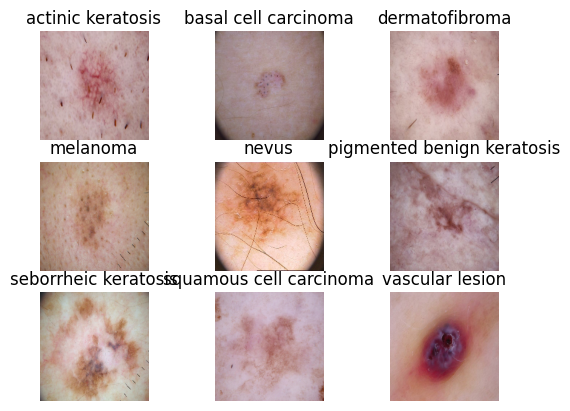

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Your code goes here

num_class = 9
model = tf.keras.Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180, 180, 3)),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_class)
])

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [15]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/20
169/169 [==============================] - 68s 221ms/step - loss: 1.9160 - accuracy: 0.2687 - val_loss: 1.6380 - val_accuracy: 0.3779
Epoch 2/20
169/169 [==============================] - 19s 115ms/step - loss: 1.4439 - accuracy: 0.4421 - val_loss: 1.3091 - val_accuracy: 0.5011
Epoch 3/20
169/169 [==============================] - 20s 118ms/step - loss: 1.2484 - accuracy: 0.5315 - val_loss: 1.1878 - val_accuracy: 0.5642
Epoch 4/20
169/169 [==============================] - 20s 117ms/step - loss: 1.0710 - accuracy: 0.6070 - val_loss: 1.1585 - val_accuracy: 0.5939
Epoch 5/20
169/169 [==============================] - 20s 116ms/step - loss: 0.9533 - accuracy: 0.6586 - val_loss: 0.9121 - val_accuracy: 0.6637
Epoch 6/20
169/169 [==============================] - 20s 116ms/step - loss: 0.7644 - accuracy: 0.7300 - val_loss: 0.8814 - val_accuracy: 0.6904
Epoch 7/20
169/169 [==============================] - 20s 117ms/step - loss: 0.5989 - accuracy: 0.7878 - val_loss: 0.8270 - val_ac

### Visualizing training results

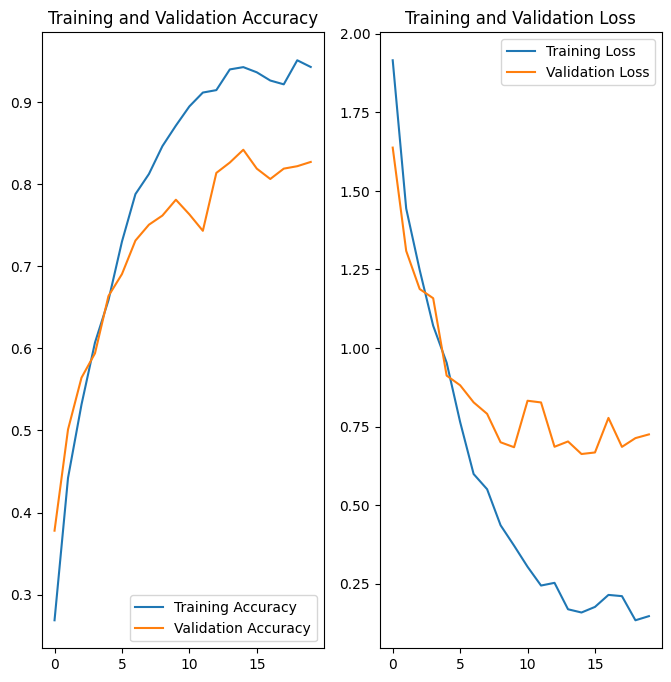

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here



*   The model is clearly overfitting, as evidenced by the validation accuracy stagnating around 51% after 20 epochs, while the training accuracy exceeds 90%.
*   The training loss steadily decreases after each epoch, but the validation loss begins to increase after the 6th epoch, indicating a reversal in performance.
*   This suggests that the model is memorizing the training data rather than generalizing and learning meaningful patterns and relationships from the data.


In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomRotation(0.2),
    ])

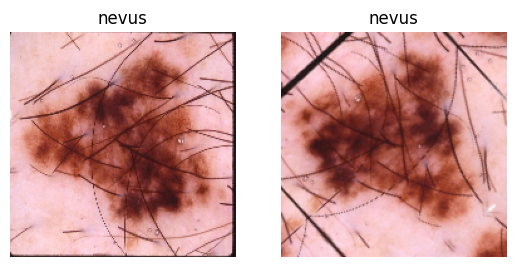

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

for image, label in train_ds.take(1):
        ax = plt.subplot(1, 2, 1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

        augmented = data_augmentation(image)
        ax = plt.subplot(1, 2, 2)
        plt.imshow(augmented[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes)
])

### Compiling the model

In [20]:
## Your code goes here

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)      ## your training code

Epoch 1/20
169/169 [==============================] - 23s 126ms/step - loss: 2.1344 - accuracy: 0.1834 - val_loss: 1.8621 - val_accuracy: 0.2687
Epoch 2/20
169/169 [==============================] - 21s 123ms/step - loss: 1.6539 - accuracy: 0.3654 - val_loss: 1.4291 - val_accuracy: 0.4581
Epoch 3/20
169/169 [==============================] - 21s 121ms/step - loss: 1.5035 - accuracy: 0.4305 - val_loss: 1.4671 - val_accuracy: 0.4454
Epoch 4/20
169/169 [==============================] - 21s 123ms/step - loss: 1.4012 - accuracy: 0.4579 - val_loss: 1.2576 - val_accuracy: 0.5130
Epoch 5/20
169/169 [==============================] - 21s 125ms/step - loss: 1.3302 - accuracy: 0.4870 - val_loss: 1.2819 - val_accuracy: 0.5108
Epoch 6/20
169/169 [==============================] - 21s 123ms/step - loss: 1.2997 - accuracy: 0.5032 - val_loss: 1.4733 - val_accuracy: 0.4722
Epoch 7/20
169/169 [==============================] - 21s 124ms/step - loss: 1.2485 - accuracy: 0.5156 - val_loss: 1.2260 - val_ac

### Visualizing the results

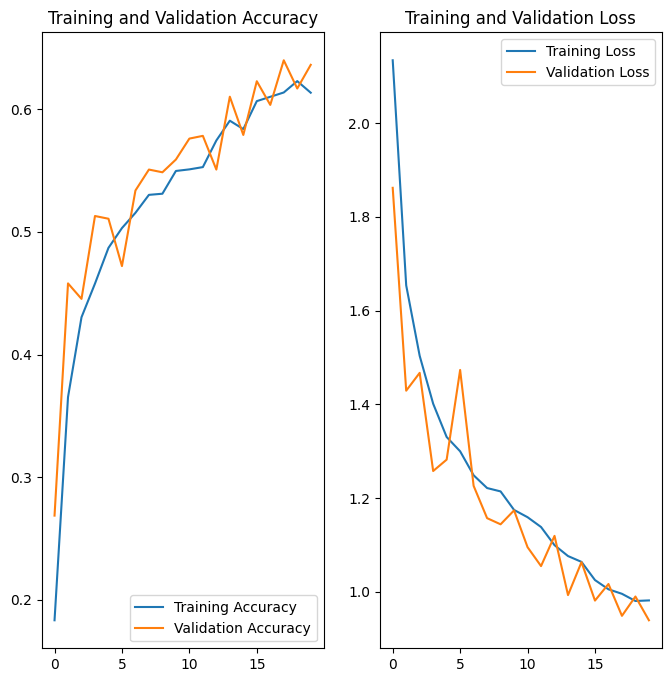

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

* Implementing data augmentation and adding a dropout layer effectively mitigated overfitting.
* The results on the training and validation datasets are more aligned, indicating that the model has successfully generalized rather than memorizing the dataset.
* While overall accuracy remains moderate, there is still a noticeable gap between training and validation accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

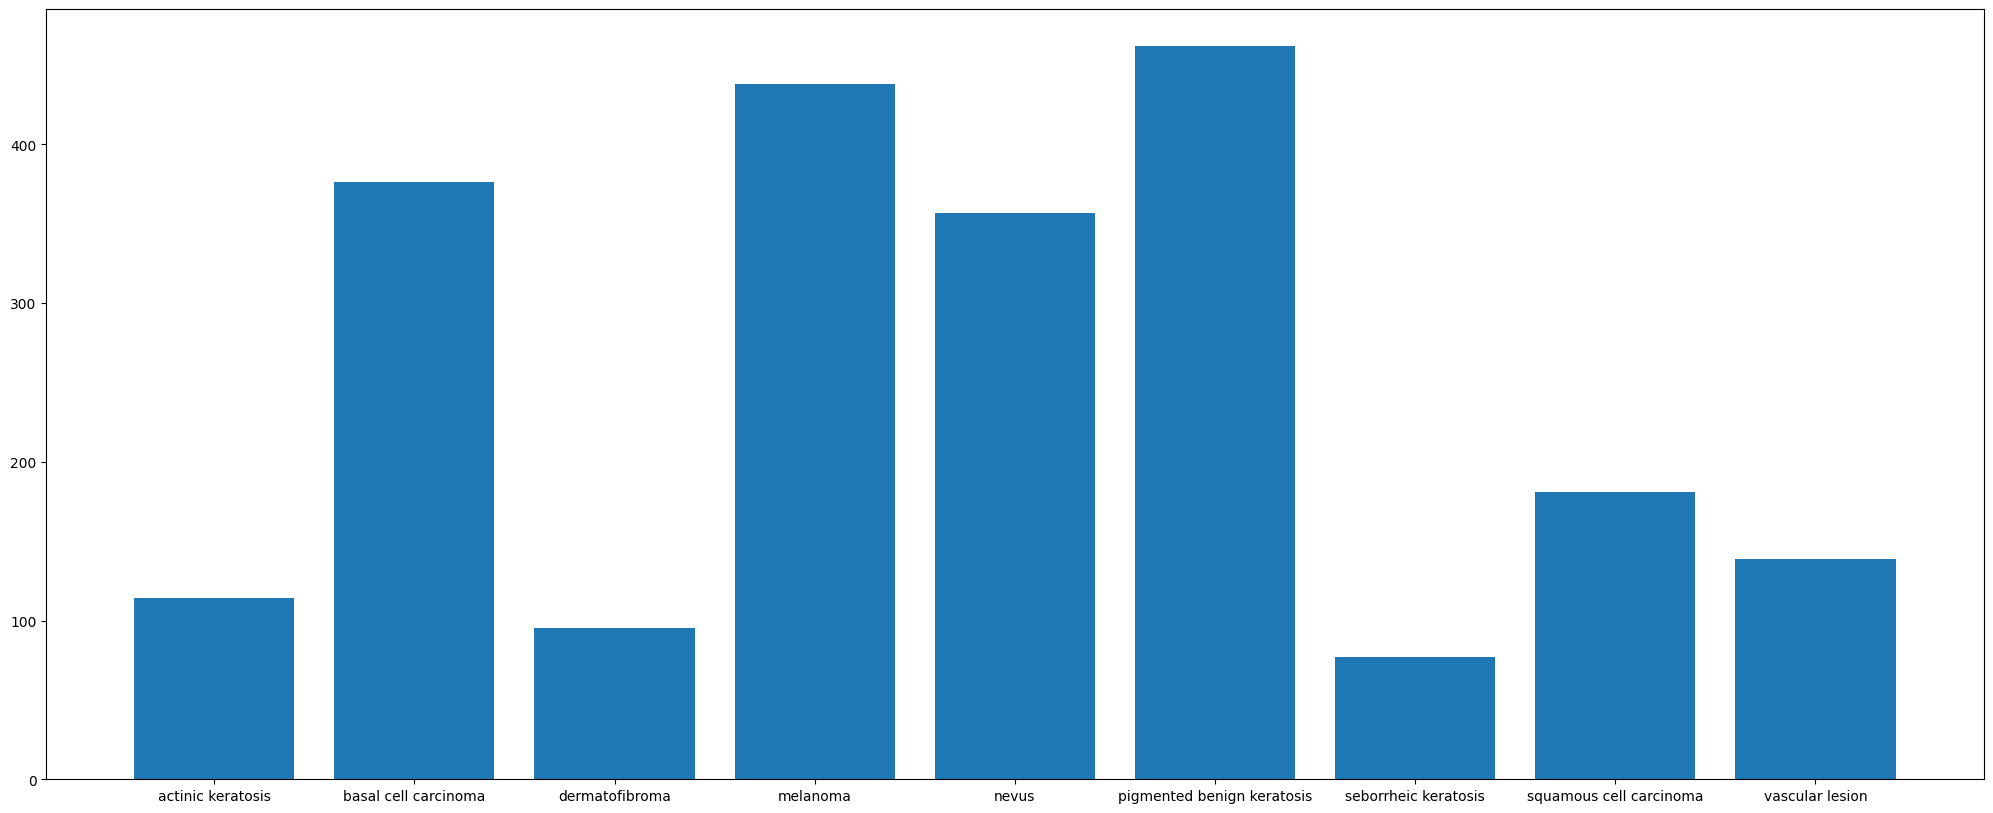

In [23]:
## Your code goes here.

class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
* seborrheic keratosis

#### - Which classes dominate the data in terms proportionate number of samples?
* pigmented benign
* melanoma
* basal cell carcinoma
* nevus

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## Adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C000616E6E0>: 100%|██████████| 500/500 [00:04<00:00, 117.57 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C000616DFF0>: 100%|██████████| 500/500 [00:04<00:00, 101.59 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C00C8100AC0>: 100%|██████████| 500/500 [00:04<00:00, 109.72 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1242x1284 at 0x7C00063E87C0>: 100%|██████████| 500/500 [00:06<00:00, 79.67 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C00D8100670>: 100%|██████████| 500/500 [00:05<00:00, 86.74 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C07A426B580>: 100%|██████████| 500/500 [00:04<00:00, 108.53 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C00C8101360>: 100%|██████████| 500/500 [00:04<00:00, 110.19 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C00E000D3F0>: 100%|██████████| 500/500 [00:04<00:00, 105.46 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C0006136A40>: 100%|██████████| 500/500 [00:04<00:00, 103.52 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028656.jpg_3ee193f9-ea19-4a49-ab2d-43d63e6fa7d0.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025419.jpg_a44d145d-6837-4a6f-88ec-12d55284f38d.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025157.jpg_4be19687-8bf7-4584-aafe-c3de322a911d.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027826.jpg_f31aea04-3e65-436c-b901-9895e802ddad.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented 

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [29]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [31]:
df2['Label'].value_counts()

,count
Label,
pigmented benign keratosis,1000
squamous cell carcinoma,1000
dermatofibroma,1000
basal cell carcinoma,1000
melanoma,1000
nevus,1000
seborrheic keratosis,1000
actinic keratosis,1000
vascular lesion,1000


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [33]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [35]:
## your code goes here

num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [36]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [37]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)         # your model fit code

Epoch 1/50
281/281 [==============================] - 40s 133ms/step - loss: 1.7836 - accuracy: 0.3124 - val_loss: 1.4174 - val_accuracy: 0.4597
Epoch 2/50
281/281 [==============================] - 38s 134ms/step - loss: 1.4146 - accuracy: 0.4480 - val_loss: 1.3592 - val_accuracy: 0.4887
Epoch 3/50
281/281 [==============================] - 37s 130ms/step - loss: 1.3184 - accuracy: 0.4867 - val_loss: 1.2668 - val_accuracy: 0.5038
Epoch 4/50
281/281 [==============================] - 37s 131ms/step - loss: 1.2184 - accuracy: 0.5226 - val_loss: 1.2276 - val_accuracy: 0.5372
Epoch 5/50
281/281 [==============================] - 37s 131ms/step - loss: 1.1984 - accuracy: 0.5360 - val_loss: 1.1431 - val_accuracy: 0.5567
Epoch 6/50
281/281 [==============================] - 37s 130ms/step - loss: 1.1487 - accuracy: 0.5550 - val_loss: 1.0925 - val_accuracy: 0.5821
Epoch 7/50
281/281 [==============================] - 36s 128ms/step - loss: 1.0831 - accuracy: 0.5816 - val_loss: 1.0339 - val_ac

#### **Todo:**  Visualize the model results

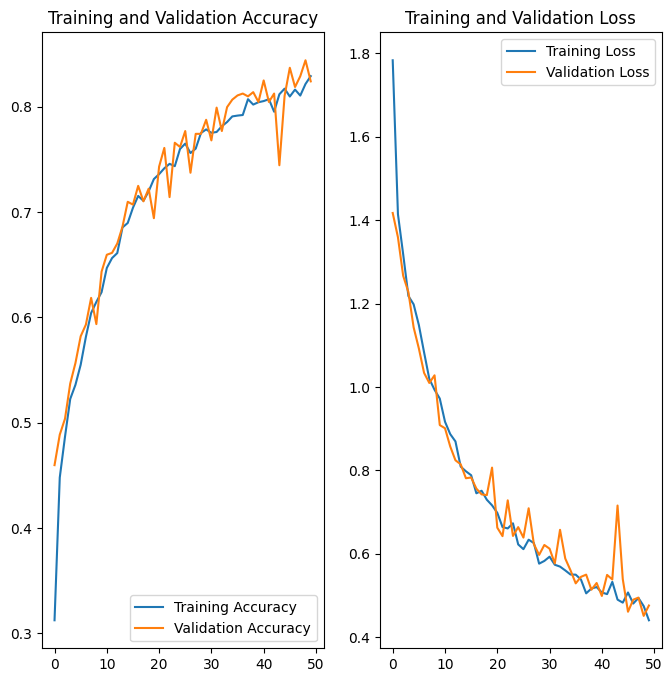

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
* Class rebalancing resolved the overfitting issue, leading to consistent performance across both the training and validation datasets.
* The accuracy improved for both the training and validation sets.
